In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import re
import os

In [2]:
os.listdir('data/sentiment140/')

['training.1600000.processed.noemoticon.csv']

In [3]:
data_df = pd.read_csv('data/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1', header=None)

In [4]:
data_df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
sentences = data_df.iloc[:,5]

In [6]:
labels = data_df.iloc[:,0]

In [7]:
def change_polarity(item):
    if item == 4:
        item = 1
    return item
        
labels = labels.map(change_polarity)

In [8]:
def remove_usernames(item):
    if item[0] == '@':
        start = item.find(' ')
        item = item[start:]
    return item
        
sentences = sentences.map(remove_usernames)

# Preprocess Text

In [9]:
from tensorflow.keras.preprocessing import text, sequence

# tokenizer = text.Tokenizer()
# tokenizer.fit_on_texts(sentences)

# saving
# with open('tokenizer_sen140.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('tokenizer_sen140.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [11]:
max_length = max([len(s.split()) for s in (sentences)])
vocab_size = len(tokenizer.word_index) + 1

sentences = tokenizer.texts_to_sequences(sentences)
sentences = sequence.pad_sequences(sentences, maxlen=max_length, padding="post")

# Split Data & Construct Dataset

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sentences, labels, 
                                                    test_size=0.20, random_state=42)

In [13]:
len(x_train), len(x_test), len(y_train), len(y_test)

(1280000, 320000, 1280000, 320000)

In [14]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

train_dataset.shuffle(BATCH_SIZE)
test_dataset.shuffle(BATCH_SIZE)

<ShuffleDataset shapes: ((128, 64), (128,)), types: (tf.int32, tf.int32)>

In [15]:
example_inp_batch, example_targ_batch = next(iter(train_dataset))
example_inp_batch.shape, example_targ_batch.shape

(TensorShape([128, 64]), TensorShape([128]))

# Define The Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate, Flatten, Embedding
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Input, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU

In [17]:
EMBEDDING_DIM = 500
LSTM_UNITS = 256

class MyLSTM(tf.keras.Model):
    def __init__(self):
        super(MyLSTM, self).__init__()
        self.embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length)
        self.dropout1 = SpatialDropout1D(0.3)
        self.lstm1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))
        self.gmp = GlobalMaxPooling1D()
        self.dense1 = Dense(100, activation='tanh')
        self.dropout2 = Dropout(0.2)
        self.denseOut = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        x = self.lstm1(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.denseOut(x)
        return x
    
model = MyLSTM()

W0412 22:12:25.416198 139788378425152 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f2282b14cc0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0412 22:12:25.418886 139788378425152 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f2282ab0550>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


# Train Model

In [18]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model=model)

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.)

def loss_function(real, pred):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.expand_dims(real, axis=1), 
                                                              pred, from_logits=True))

In [20]:
@tf.function
def train_step(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        preds = model(inp)
        loss += loss_function(targ, preds)
    
    trn_acc_metric.update_state(targ, preds)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [21]:
@tf.function
def val_step(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        preds = model(inp)
        loss += loss_function(targ, preds)
    
    val_acc_metric.update_state(targ, preds)
    return tf.reduce_mean(loss)

In [22]:
import time

trn_acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
val_acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

steps_per_epoch = len(x_train)//BATCH_SIZE

EPOCHS = 20
trn_loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0
    
    hidden = model.reset_states()
    for batch, ((trn_inp, trn_targ), (val_inp, val_targ)) in enumerate(zip(train_dataset.take(steps_per_epoch), test_dataset.take(steps_per_epoch))):
        batch_loss = train_step(trn_inp, trn_targ)
        total_loss += batch_loss
        trn_loss_list.append(batch_loss)

        val_loss = val_step(val_inp, val_targ)
        val_total_loss += val_loss
        val_loss_list.append(val_loss)

        if batch%100==0:
              print('Epoch {} Batch {} Trn Loss {:.4f} Val Loss {:.4f} Trn_Acc {:.2f} Val_Acc {:.2f}'.format(epoch + 1,
                                                                                                             batch,
                                                                                                             batch_loss.numpy(),
                                                                                                             val_loss.numpy(),
                                                                                                             trn_acc_metric.result().numpy(),
                                                                                                             val_acc_metric.result().numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Trn Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Epoch {} Val Loss {:.4f}'.format(epoch + 1,
                                      val_total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Trn Loss 0.7206 Val Loss 0.7233 Trn_Acc 0.52 Val_Acc 0.50
Epoch 1 Batch 100 Trn Loss 0.6931 Val Loss 0.6930 Trn_Acc 0.51 Val_Acc 0.50
Epoch 1 Batch 200 Trn Loss 0.6932 Val Loss 0.6930 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 300 Trn Loss 0.6931 Val Loss 0.6931 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 400 Trn Loss 0.6931 Val Loss 0.6932 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 500 Trn Loss 0.6932 Val Loss 0.6931 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 600 Trn Loss 0.6933 Val Loss 0.6931 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 700 Trn Loss 0.6932 Val Loss 0.6930 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 800 Trn Loss 0.6931 Val Loss 0.6929 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 900 Trn Loss 0.7012 Val Loss 0.6956 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 1000 Trn Loss 0.6941 Val Loss 0.6794 Trn_Acc 0.51 Val_Acc 0.51
Epoch 1 Batch 1100 Trn Loss 0.7544 Val Loss 0.6272 Trn_Acc 0.52 Val_Acc 0.52
Epoch 1 Batch 1200 Trn Loss 0.6430 Val Loss 0.6504 Trn_Acc 0.53 Val_Acc 0.53
Epoch 1 Bat

Epoch 5 Batch 300 Trn Loss 0.5461 Val Loss 0.5734 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 400 Trn Loss 0.5630 Val Loss 0.6554 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 500 Trn Loss 0.5978 Val Loss 0.6300 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 600 Trn Loss 0.6023 Val Loss 0.5692 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 700 Trn Loss 0.6105 Val Loss 0.5825 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 800 Trn Loss 0.5938 Val Loss 0.5872 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 900 Trn Loss 0.5970 Val Loss 0.6022 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 1000 Trn Loss 0.5489 Val Loss 0.5973 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 1100 Trn Loss 0.5702 Val Loss 0.5972 Trn_Acc 0.77 Val_Acc 0.75
Epoch 5 Batch 1200 Trn Loss 0.5679 Val Loss 0.6113 Trn_Acc 0.78 Val_Acc 0.75
Epoch 5 Batch 1300 Trn Loss 0.5695 Val Loss 0.6151 Trn_Acc 0.78 Val_Acc 0.75
Epoch 5 Batch 1400 Trn Loss 0.5719 Val Loss 0.5847 Trn_Acc 0.78 Val_Acc 0.75
Epoch 5 Batch 1500 Trn Loss 0.5610 Val Loss 0.6163 Trn_Acc 0.78 Val_Acc 0.75
Epoch 

Epoch 9 Batch 600 Trn Loss 0.5875 Val Loss 0.5740 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 700 Trn Loss 0.6048 Val Loss 0.5748 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 800 Trn Loss 0.5764 Val Loss 0.5852 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 900 Trn Loss 0.5974 Val Loss 0.6101 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1000 Trn Loss 0.5399 Val Loss 0.6164 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1100 Trn Loss 0.5636 Val Loss 0.6054 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1200 Trn Loss 0.5591 Val Loss 0.6088 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1300 Trn Loss 0.5654 Val Loss 0.6206 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1400 Trn Loss 0.5502 Val Loss 0.5779 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1500 Trn Loss 0.5521 Val Loss 0.6281 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1600 Trn Loss 0.5732 Val Loss 0.5759 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1700 Trn Loss 0.5526 Val Loss 0.5742 Trn_Acc 0.81 Val_Acc 0.77
Epoch 9 Batch 1800 Trn Loss 0.5722 Val Loss 0.5917 Trn_Acc 0.81 Val_Acc 0.77
Epo

Epoch 13 Batch 700 Trn Loss 0.5935 Val Loss 0.5744 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 800 Trn Loss 0.5654 Val Loss 0.6016 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 900 Trn Loss 0.5897 Val Loss 0.6013 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1000 Trn Loss 0.5353 Val Loss 0.6025 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1100 Trn Loss 0.5491 Val Loss 0.6169 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1200 Trn Loss 0.5492 Val Loss 0.5991 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1300 Trn Loss 0.5616 Val Loss 0.6242 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1400 Trn Loss 0.5400 Val Loss 0.5847 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1500 Trn Loss 0.5503 Val Loss 0.6143 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1600 Trn Loss 0.5750 Val Loss 0.5710 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1700 Trn Loss 0.5368 Val Loss 0.5676 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1800 Trn Loss 0.5594 Val Loss 0.5961 Trn_Acc 0.83 Val_Acc 0.77
Epoch 13 Batch 1900 Trn Loss 0.5793 Val Loss 0.5648 Trn_Acc 0.83 Va

Epoch 17 Batch 800 Trn Loss 0.5598 Val Loss 0.5969 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 900 Trn Loss 0.5852 Val Loss 0.5955 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1000 Trn Loss 0.5404 Val Loss 0.6199 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1100 Trn Loss 0.5422 Val Loss 0.6179 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1200 Trn Loss 0.5507 Val Loss 0.6103 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1300 Trn Loss 0.5693 Val Loss 0.6226 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1400 Trn Loss 0.5448 Val Loss 0.5935 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1500 Trn Loss 0.5373 Val Loss 0.6140 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1600 Trn Loss 0.5661 Val Loss 0.5833 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1700 Trn Loss 0.5301 Val Loss 0.5803 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1800 Trn Loss 0.5562 Val Loss 0.5811 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 1900 Trn Loss 0.5771 Val Loss 0.5690 Trn_Acc 0.84 Val_Acc 0.78
Epoch 17 Batch 2000 Trn Loss 0.5511 Val Loss 0.6427 Trn_Acc 0.84 V

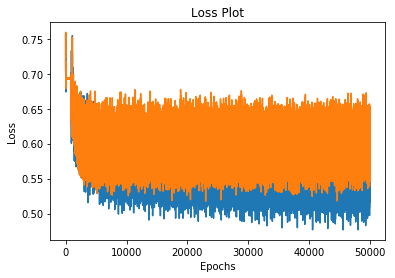

In [27]:
import matplotlib.pyplot as plt

plt.plot(trn_loss_list)
plt.plot(val_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [28]:
model.save_weights('pre-deploy_models/sen140Eager.h5')

# Test Sentences

In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import re
import os
from tensorflow.keras.preprocessing import text, sequence


with open('tokenizer_sen140.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

vocab_size = len(tokenizer.word_index) + 1
max_length = 64
    
test_sentence = 'Sapura Energy bags 5 new contracts worth RM1.3 billion - Free Malaysia Today'
test_sentence = tokenizer.texts_to_sequences(test_sentence)
test_sentence = sequence.pad_sequences(test_sentence, maxlen=max_length, padding="post")

In [30]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate, Flatten, Embedding
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Input, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU

EMBEDDING_DIM = 500
LSTM_UNITS = 256

class MyLSTM(tf.keras.Model):
    def __init__(self):
        super(MyLSTM, self).__init__()
        self.embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length)
        self.dropout1 = SpatialDropout1D(0.3)
        self.lstm1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))
        self.gmp = GlobalMaxPooling1D()
        self.dense1 = Dense(100, activation='tanh')
        self.dropout2 = Dropout(0.2)
        self.denseOut = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        x = self.lstm1(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.denseOut(x)
        return x
    
model = MyLSTM()

model.load_weights('pre-deploy_models/sen140Eager.h5')

W0413 00:08:46.850948 139788378425152 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f21f04ba128>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0413 00:08:46.852722 139788378425152 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f21f04ba400>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [38]:
test_sentence = ['Sapura Energy bags 5 new contracts worth RM1.3 billion - Free Malaysia Today', 
                 'BREAKING: Trump just signed two executive orders that seek to expedite permits for pipelines and other fossil fuel projects by restricting public input and states authority.',
                'Number of companies producing oil and gas in Western Canada drops 17.5% since 2014']

# test_sentence = ['Wheelchair customers stuck out in the pouring rain when the cab was booked in advance is OUTRAGEOUS. This cab is now 55 minutes late and my client has missed a VERY important DRs appt. BRING #Uber TO VANCOUVER if anything just to SCREW with @vancouvertaxi customers. @NEWS1130',
#                 'Uber worst service... Cab booked to take 1.5 year child to doctor and cab did not come more then 1hr driver not answering and not cancelling the ride...',
#                 'That #Uber ad sums up that company!! I’ve no sympathy for anyone male or female who uses em and becomes unstuck! They’re not even fucking cheap that’s a myth! Use your local mini cab firm n black cabs in London! Let’s keep money in England ay n drive this firm out!']

# example_inp_batch, example_targ_batch = next(iter(test_dataset))
# example_inp_batch

In [39]:
test_sentence = tokenizer.texts_to_sequences(test_sentence)
test_sentence = sequence.pad_sequences(test_sentence, maxlen=max_length, padding="post")

In [44]:
model.predict(test_sentence)

array([[0.50469756],
       [0.5047392 ],
       [0.5026513 ]], dtype=float32)